In [1]:
import traitlets, requests, ipywidgets, pandas, jinja2, IPython, odo, multipledispatch, blaze, logging, http, sys, json, matplotlib
from coffeetools import coffee
%reload_ext autoreload
%matplotlib notebook
%autoreload 2
IPython.display.Javascript( coffee.compile("""
window.update = ( selection, data, tag = 'div',  classes = [] )->
    selection = selection.selectAll [tag, classes...].join '.'
        .data data
    selection.enter().append tag
    for c in classes
        selection.classed c, true
    selection.exit().remove()
    selection
"""))
get_ipython = ipywidgets.get_ipython

/Users/tfast/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
@odo.resource.register( 'gh://.*' )
def github__shorthand_resource( path, *args, **kwargs ):
    """Get user or repository level information."""
    __route__ = 'gh://'
    user = path.split( __route__ )[1].split('/')
    user, repo = user if len(user) == 2 else [user[0],'']
    method = 'repos' if repo else 'users'    
    return jinja2.Template( 'https://api.github.com/{{method}}/{{user}}/{{repo}}').render(**locals()).rstrip('/')

In [3]:
@multipledispatch.dispatch( str, dict, requests.sessions.Session )
def github_request( url, params = {}, session = requests.Session() ):
    """
    Make the URL when a url is passed to the function
    
            req, resp = github_request('tonyfast', {}, requests.Session() )
    """
    if not url.startswith('http'):
        url = odo.resource( 'gh://' + url )
    request = requests.Request('GET', url=url, params=params.copy(), headers={'User-Agent': 'tonyfast'} )
    request.params =  request.params 
    return request, session.send( request.prepare() )

@multipledispatch.dispatch( requests.models.Request, requests.models.Response )
def github_request( requests, response ):
    del requests.params['access_token']
    return requests.prepare(), response.json()

In [4]:
class Projects( traitlets.HasTraits ):
    current = traitlets.List([])
    access_token = ipywidgets.Text('asdfadf')
    username = ipywidgets.Text('tonyfast')
    columns = ipywidgets.SelectMultiple( options=['<Empty>'] )
    df = pandas.DataFrame()
    urls = ipywidgets.Textarea( """""", width = 800 )
    row = ipywidgets.FloatSlider( description='Row Index', min=0, max=1, step=1 )
    session = requests.Session()
    catalog = {}   
    num_row = 10
    
    def __init__( self, projects = [], *args, **kwargs ):
        self.env = jinja2.Environment( loader = jinja2.FileSystemLoader('_layouts') )
        for project in projects:
            self.add_project( project )
        self.row.observe(names='value', handler=self.row_change)
        self.columns.observe(names='selected_labels', handler=self.col_change)

    def table_html( self ):
        return IPython.display.HTML(self.env.get_template('table.html').render())
    
    def table( self ):
         return IPython.display.display( self.table_html() )    


    def row_change( self, change ):
        if not isinstance( change['new'], dict ):
            self.row_update( int(change['new']) )

    def col_change( self, change ):
        if not isinstance( change['new'], dict ):
            self.row_update()

    def row_update( self, i=None ):
        if not i:
            i = self.row.value
        if len(self.columns.options) > 1:
            value = self.env.get_template('update_table.coffee').render( 
                df = self.df[list(self.columns.selected_labels)].iloc[i:i+self.num_row].to_json(orient='split') 
            )
            IPython.display.display( 
                IPython.display.Javascript( 
                    coffee.compile(
                        value, bare=True
                    )
                )
            )
    
        
    @traitlets.observe('current')
    def _update_projects(self, change, *args, **kwargs):
        for project in change['new']:            
            if not project in change['old']:
                self._make_request( project, alias=project )

    def _make_request( self, project_or_url, params = {}, alias=None ):  
        params['access_token'] = self.access_token.value
        recorded = self._record( *github_request( project_or_url, params, self.session ) )
        if alias:
            if isinstance( alias, str ):
                self.catalog[alias] = recorded
        
    def _record( self, request, response ):
        del request.params['access_token']
        url = request.prepare().url
        if isinstance( url, str ):
            self.catalog[url] = {
                'response': response,
                'time': str(pandas.datetime.now()),
                'params': request.params.copy(),
                'request': request,
                'url': url
            } 
            obj = self.catalog[url]['response'].json()
            self._update_dataframe( obj )
            return self.catalog[url] 

    def _update_dataframe( self, obj ):
        if isinstance( obj, list ):
            self.df = self.df.append( obj )
            new_col = []
            for c in self.df.columns:
                if not c in self.columns.options:
                    new_col.append( c )
            self.columns.options = [c for c in self.columns.options + new_col if not c in ['<Empty>']]
            self.row.max = self.df.shape[0] - self.num_row
            
    def _paginate( self, project_or_url, params ):
        params['page'] = 0
        for k,v in self.catalog.items(): 
            if k.startswith(project_or_url) and isinstance( v['response'].json(), list ):
                params['page'] = max( params['page'], v['params']['page'])
        params['page'] += 1
        return params
                                
    def more( self, project_or_url, params = {} ):
        params = self._paginate( project_or_url, params )
        self._make_request( project_or_url, params, self.session )
        self.urls.value = '\n'.join(self.catalog.keys())
        
    def add_project( self, project ):
        tmp = self.current.copy()
        tmp.append(project)
        self.current = tmp

In [5]:
projects = Projects(['bokeh/bokeh','jupyter/jupyter'])

In [6]:
projects.more(projects.catalog['bokeh/bokeh']['response'].json()['issues_url'].split('{')[0])
projects.more(projects.catalog['bokeh/bokeh']['response'].json()['issues_url'].split('{')[0])

/Users/tfast/anaconda/lib/python3.4/site-packages/pandas/core/indexing.py:1227: FutureWarning: slice indexers when using iloc should be integers and not floating point
  return self._getitem_axis(key, axis=0)


<IPython.core.display.Javascript object>

In [7]:
repos = {k: v for k, v in projects.catalog.items() if not k.startswith('http')}

In [10]:
projects.urls

In [18]:
def repo_buttons( repo = projects.current[0] ):
    obj = projects.catalog[repo]['response'].json()
    row,buttons = [[],[]]
    for k,v in obj.items():
        if len(row) == 6:
            buttons.append( ipywidgets.HBox( children=row ) )
            row = []
        if k.endswith('_url'):
            if v:
                button = ipywidgets.Button( description=k )
                button.url = v.split('{')[0] if '{' in v else v
                button.on_click( lambda s: projects.more(s.url))
                row.append(button)
    if len(row) > 0:
        buttons.append( ipywidgets.HBox( children=row ) )
    return IPython.display.display(*buttons)
repo_buttons(projects.current[1])

In [9]:
projects.columns.height = 600
projects.columns

/Users/tfast/anaconda/lib/python3.4/site-packages/pandas/core/indexing.py:1227: FutureWarning: slice indexers when using iloc should be integers and not floating point
  return self._getitem_axis(key, axis=0)


<IPython.core.display.Javascript object>

In [13]:
projects.row

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
projects.table()

# Spare Matrix of the frame

As each request appends to the dataframe the rows have an intrinsic sparsity

<IPython.core.display.Javascript object>


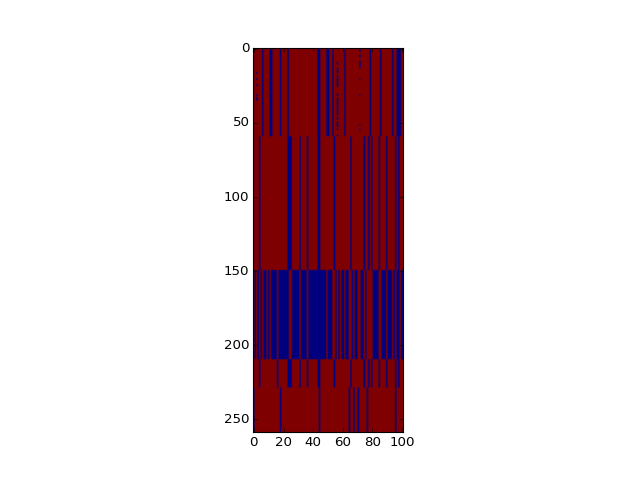

In [20]:
%matplotlib notebook
matplotlib.pyplot.imshow(projects.df.isnull().values)

In [50]:
%%file _layouts/table.html
<table id="catalog" class="table"></table>

Overwriting _layouts/table.html


In [11]:
%%file _layouts/update_table.coffee
debugger
data = {{df}}
table = d3.select '#catalog'
header = table.selectAll 'tr.header'
    .data [ '', data['columns'] ]
header.enter().append('tr').classed 'header', true
header.each (d)->
    cells = d3.select(@).selectAll('th').data d
    cells.enter().append 'th'
    cells.text (d)-> d
    cells.exit().remove()
header.exit().remove()
value = table.selectAll 'tr.value'
    .data data['data']
value.enter().append('tr').classed 'value', true
value.each (row)->
    cells = d3.select @
        .selectAll 'td'
        .data row
    cells.enter().append 'td'
    cells.text (v)-> JSON.stringify v
    cells.exit().remove()  
value.exit().remove()

Overwriting _layouts/update_table.coffee
